<a href="https://colab.research.google.com/github/Tanisha2626/Analysis_of_taxi_Industry_in_NYC/blob/main/Analysis_of_Taxi_ind2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
import calendar
import matplotlib.dates as mdates
from math import radians, cos, sin, asin, sqrt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
!pip install livelossplot
from livelossplot import PlotLossesKerasTF
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random
random.seed(0)
print(tf.__version__)

In [ ]:
#2016 NYC Yellow Cab Trip Data
train_df = pd.read_csv('/content/drive/MyDrive/analysis_of_taxi_ind/PROJECT/train.csv')

In [ ]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Pre-processing and EDA

In [ ]:
#conversion to date-time object
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
train_df['dropoff_datetime'] = pd.to_datetime(train_df['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
#checking for missing values
train_df[pd.isnull(train_df)].sum()

id                    0.0
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

In [ ]:
#range of data set dates
print('--------------------Training Data------------------------------')
print("Earliest timestamp in dataset:", min(train_df['pickup_datetime']))
print("Latest timestamp in dataset:", max(train_df['pickup_datetime']))

--------------------Training Data------------------------------
Earliest timestamp in dataset: 2016-01-01 00:00:17
Latest timestamp in dataset: 2016-06-30 23:59:39


The data is from 2016 only

In [ ]:
train_df['pickup_day'] = train_df['pickup_datetime'].apply(lambda x : x.month + x.day / 31)
train_df['pickup_time'] = train_df['pickup_datetime'].apply(lambda x : x.hour + x.minute / 60)
train_df['pickup_day_of_week'] = train_df['pickup_datetime'].apply(lambda x : calendar.day_name[x.weekday()])

train_df['dropoff_day'] = train_df['dropoff_datetime'].apply(lambda x : x.month + x.day / 31)
train_df['dropoff_time'] = train_df['dropoff_datetime'].apply(lambda x : x.hour + x.minute / 60)
train_df['dropoff_day_of_week'] = train_df['dropoff_datetime'].apply(lambda x : calendar.day_name[x.weekday()])

In [ ]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_time,pickup_day_of_week,dropoff_day,dropoff_time,dropoff_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3.451613,17.400000,Monday,3.451613,17.533333,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.387097,0.716667,Sunday,6.387097,0.900000,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1.612903,11.583333,Tuesday,1.612903,12.166667,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4.193548,19.533333,Wednesday,4.193548,19.650000,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3.838710,13.500000,Saturday,3.838710,13.633333,Saturday


As we are interested in the duration of trip, the distances between pickup and  drop locations will be important

We shall be using the Haversine formula


In [ ]:
def distance(row):#Ref: https://www.geeksforgeeks.org/program-distance-two-points-earth/

    lat1, lat2, lon1, lon2 = row['pickup_latitude'], row['dropoff_latitude'], row['pickup_longitude'], row['dropoff_longitude']

    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    angle = 2 * asin(sqrt(sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2)**2))

    radius = 6371

    return(angle * radius)

In [ ]:
train_df['distance'] = train_df.apply(lambda row : distance(row), axis =1)
train_df['avg_speed'] = train_df['distance'] / train_df['trip_duration']
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_time,pickup_day_of_week,dropoff_day,dropoff_time,dropoff_day_of_week,distance,avg_speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3.451613,17.400000,Monday,3.451613,17.533333,Monday,1.498521,0.003293
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.387097,0.716667,Sunday,6.387097,0.900000,Sunday,1.805507,0.002723
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1.612903,11.583333,Tuesday,1.612903,12.166667,Tuesday,6.385098,0.003006
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4.193548,19.533333,Wednesday,4.193548,19.650000,Wednesday,1.485498,0.003463
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3.838710,13.500000,Saturday,3.838710,13.633333,Saturday,1.188588,0.002732


we shall see distributions of trip duration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Trip duration distribution')

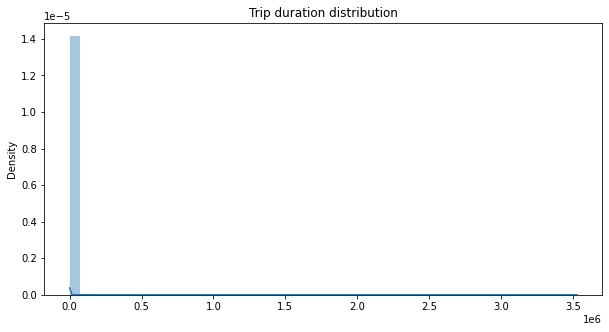

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(x = train_df['trip_duration'])
plt.title('Trip duration distribution')

It seems that the trip duration is very much concentrated at one place, hence we shall use log-scale on x-axis

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'log-scale trip duration distribution')

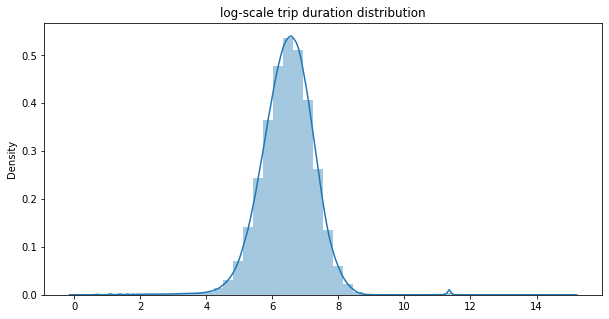

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(x = np.log(train_df['trip_duration']))
plt.title('log-scale trip duration distribution')

This distribution is very close to normal distribution, with most of the values for trip duration between 4 to 8 on log scale, that is, 54 sec to 2981 sec.

In [ ]:
train_df.drop(train_df[train_df['trip_duration'] > 3000].index, inplace = True)
print(train_df.shape)

(1434821, 19)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'log-scale trip duration distribution')

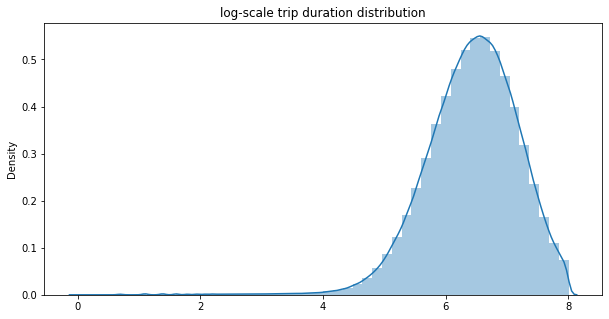

In [ ]:
#log scale distribution after removing outlier points
plt.figure(figsize = (10,5))
sns.distplot(x = np.log(train_df['trip_duration']))
plt.title('log-scale trip duration distribution')

As we can see, the distribution has not been changed much due to removal of outlier points

distance distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'distance travelled distribution')

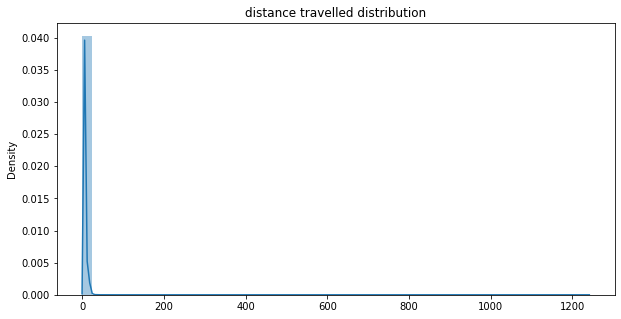

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(x = train_df['distance'])
plt.title('distance travelled distribution')

Similar to time duration, we should try out the log-scale to get a better view at the data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'log-scale trip distance distribution')

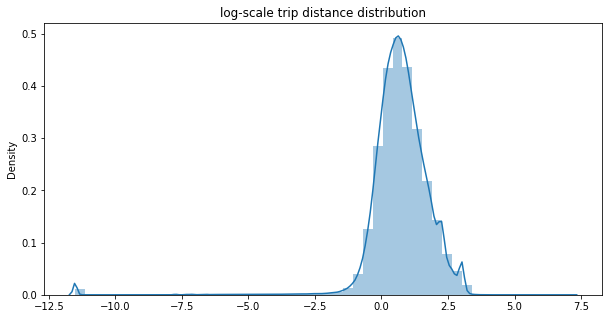

In [ ]:
plt.figure(figsize = (10,5))
#adding a small number to avoid the zero inside log
sns.distplot(x = np.log(0.00001 + train_df['distance']))
plt.title('log-scale trip distance distribution')

For the trip distance too, the distribution is close to normal with most of the values being in -2.5 to 2.5 on log scale, that is, 0.082 km to 12.182 km

In [ ]:
#removing outlier points for distance too
train_df.drop(train_df[train_df['distance'] > 13].index, inplace = True)
print(train_df.shape)

(1393208, 19)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'log-scale trip distance distribution')

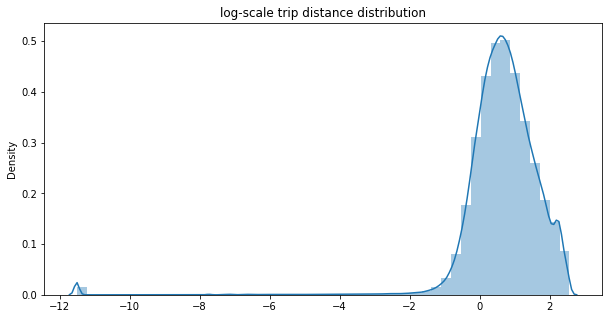

In [ ]:
plt.figure(figsize = (10,5))
#adding a small number to avoid the zero inside log
sns.distplot(x = np.log(0.00001 + train_df['distance']))
plt.title('log-scale trip distance distribution')

Number of rides on different weekdays

Text(0.5, 1.0, 'Number of trips according to weekdays from dataset')

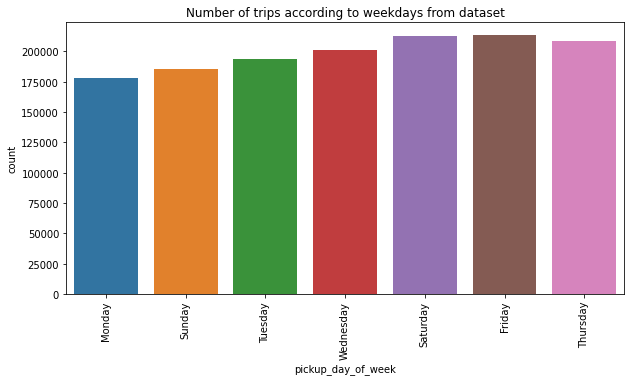

In [ ]:
plt.figure(figsize = (10,5))
plt.xticks(rotation=90)
sns.countplot(x = train_df['pickup_day_of_week'])
plt.title('Number of trips according to weekdays from dataset')

Though all of the days do not have much difference in number of trips as compared to the number of trips, friday has highest number of trips, counts can be seen below as 213439

In [ ]:
train_df['pickup_day_of_week'].value_counts()

Friday       213439
Saturday     212795
Thursday     208411
Wednesday    200991
Tuesday      194056
Sunday       185622
Monday       177894
Name: pickup_day_of_week, dtype: int64

Average Speed Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Average speed distribution (log-scale)')

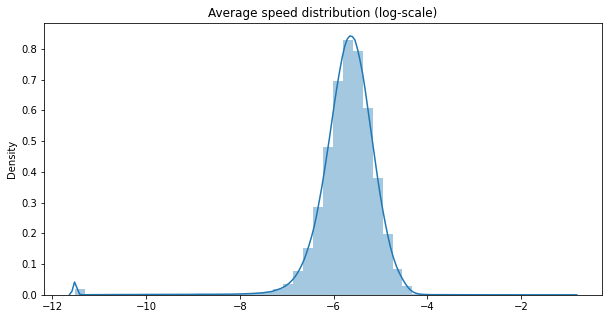

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(x = np.log(0.00001 + train_df['avg_speed']))
plt.title('Average speed distribution (log-scale)')

As expected, the speed follows as normal distribution, with most of the values in -8 to -4 on log-scale, that is, 0.0003354 km/sec to 0.0183 km/sec

Taking available attributes(those available for testing data too) to get the heat map, only numerical features

In [ ]:
#Mean and standard deviation of pickup and dro locations
print('-------------------Pickup Longitude-------------------')
print('Mean:', np.mean(train_df['pickup_longitude']))
print('Std. Deviation:', np.std(train_df['pickup_longitude']))
print('-------------------Pickup Latitude-------------------')
print('Mean:', np.mean(train_df['pickup_latitude']))
print('Std. Deviation:', np.std(train_df['pickup_latitude']))
print('-------------------Dropoff Longitude-------------------')
print('Mean:', np.mean(train_df['dropoff_longitude']))
print('Std. Deviation:', np.std(train_df['dropoff_longitude']))
print('-------------------Dropoff Latitude-------------------')
print('Mean:', np.mean(train_df['dropoff_latitude']))
print('Std. Deviation:', np.std(train_df['dropoff_latitude']))

-------------------Pickup Longitude-------------------
Mean: -73.97747069756771
Std. Deviation: 0.06634475001643511
-------------------Pickup Latitude-------------------
Mean: 40.75290252393932
Std. Deviation: 0.026946459845785534
-------------------Dropoff Longitude-------------------
Mean: -73.97538255143783
Std. Deviation: 0.06655193324370191
-------------------Dropoff Latitude-------------------
Mean: 40.75303251151853
Std. Deviation: 0.030927456028834347


The standard deviation of all the above parameters is very small, hence we can infer that the trips are limited to a particular area and indeed it was correct to remove some outlier points according to distance and time from the dataset

In [ ]:
available_attributes = ['vendor_id', 'passenger_count','pickup_longitude','pickup_latitude',
                        'dropoff_longitude','dropoff_latitude','trip_duration',
                        'pickup_time','distance']

In [ ]:
corr_df = train_df[available_attributes]
corr_df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_time,distance
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,17.400000,1.498521
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,0.716667,1.805507
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11.583333,6.385098
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,19.533333,1.485498
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,13.500000,1.188588


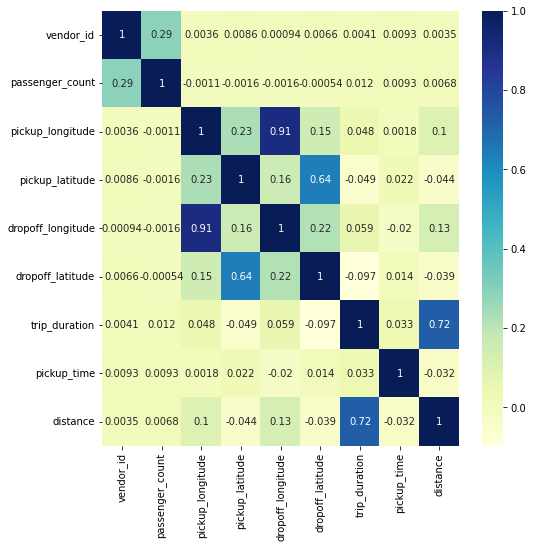

In [ ]:
plt.figure(figsize=(8,8))
corr = corr_df.corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu" )

The heat map shows that, the distance has a high correlation with the duration of trip and the correlation between pickup and drop location parameters shows that they are not far away from each other

In [ ]:
train = train_df[['vendor_id','passenger_count','pickup_longitude','pickup_latitude',
                  'dropoff_longitude','dropoff_latitude','store_and_fwd_flag','trip_duration',
                  'pickup_day','pickup_time','pickup_day_of_week','distance']]
                  #dropping the trip id as it is just an identifier

#one hot encoding
train = pd.concat([train.drop('pickup_day_of_week', axis = 1), pd.get_dummies(train['pickup_day_of_week'])], axis = 1)
train = pd.concat([train.drop('store_and_fwd_flag', axis = 1), pd.get_dummies(train['store_and_fwd_flag'])], axis = 1)
train = pd.concat([train.drop('vendor_id', axis = 1), pd.get_dummies(train['vendor_id'], prefix = 'vendor_id')], axis = 1)
train.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_time,distance,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,N,Y,vendor_id_1,vendor_id_2
0,1,-73.982155,40.767937,-73.964630,40.765602,455,3.451613,17.400000,1.498521,0,1,0,0,0,0,0,1,0,0,1
1,1,-73.980415,40.738564,-73.999481,40.731152,663,6.387097,0.716667,1.805507,0,0,0,1,0,0,0,1,0,1,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1.612903,11.583333,6.385098,0,0,0,0,0,1,0,1,0,0,1
3,1,-74.010040,40.719971,-74.012268,40.706718,429,4.193548,19.533333,1.485498,0,0,0,0,0,0,1,1,0,0,1
4,1,-73.973053,40.793209,-73.972923,40.782520,435,3.838710,13.500000,1.188588,0,0,1,0,0,0,0,1,0,0,1


In [ ]:
#Normalizing
columns = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_day','pickup_time','distance']
for c in columns:
    mean = np.mean(train[c])
    std = np.std(train[c])
    train[c] = (train[c] - mean) / (0.0001 + std)
train.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_time,distance,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,N,Y,vendor_id_1,vendor_id_2
0,-0.50378,-0.070497,0.555865,0.161322,0.405112,455,-0.329111,0.514711,-0.547374,0,1,0,0,0,0,0,1,0,0,1
1,-0.50378,-0.044317,-0.530161,-0.361560,-0.705212,663,1.398455,-2.089135,-0.417161,0,0,0,1,0,0,0,1,0,1,0
2,-0.50378,-0.023419,0.408053,-0.449355,-1.384119,2124,-1.411213,-0.393123,1.525342,0,0,0,0,0,1,0,1,0,0,1
3,-0.50378,-0.490175,-1.217602,-0.553405,-1.492680,429,0.107526,0.847671,-0.552898,0,0,0,0,0,0,1,1,0,0,1
4,-0.50378,0.066487,1.490271,0.036897,0.950377,435,-0.101300,-0.093980,-0.678837,0,0,1,0,0,0,0,1,0,0,1


In [ ]:
#using 90% of dataset to train
train_dataset = train.sample(frac=0.9, random_state=0)
test_dataset = train.drop(train_dataset.index)
print('Number of training Samples:',train_dataset.shape[0])
print('Number fo test Samples:',test_dataset.shape[0])

Number of training Samples: 1253887
Number fo test Samples: 139321


In [ ]:
#building a neural netowrk model, Ref: https://www.tensorflow.org/tutorials/keras/regression
def build_and_compile_model():
    model = keras.Sequential([
    keras.Input(shape=(19,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                    optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [ ]:
model = build_and_compile_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2560      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 693,505
Trainable params: 693,505
Non-trai

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('trip_duration')
test_labels = test_features.pop('trip_duration')

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(131072)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features,test_labels)).batch(131072)

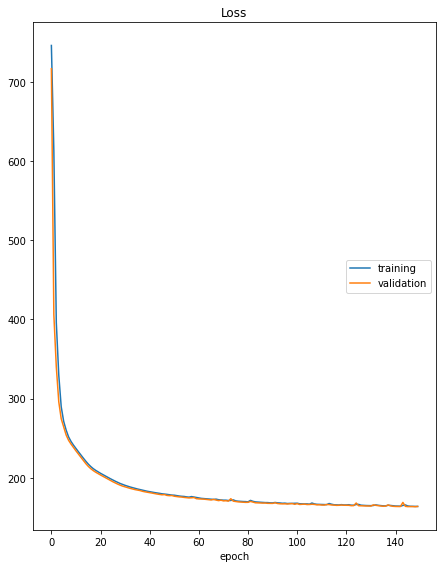

Loss
	training         	 (min:  163.732, max:  745.943, cur:  163.732)
	validation       	 (min:  163.379, max:  716.576, cur:  163.791)

Epoch 00150: val_loss did not improve from 163.37881


In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/SEM 7/DS 203/PROJECT/model_weight.h5", monitor='val_loss',save_best_only=True,
                             save_weights_only=False, mode='min', verbose=1)

callbacks = [PlotLossesKerasTF(), checkpoint]
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    verbose=0, epochs=150,
    callbacks = callbacks
    )

The validation loss and training loss are always close to each other, hence we can infer that the model is not ovefitting at all

In [ ]:
y_pred = model.predict(test_features[:1000])

Prdiction for 1000 test cases vs real values of trip duration

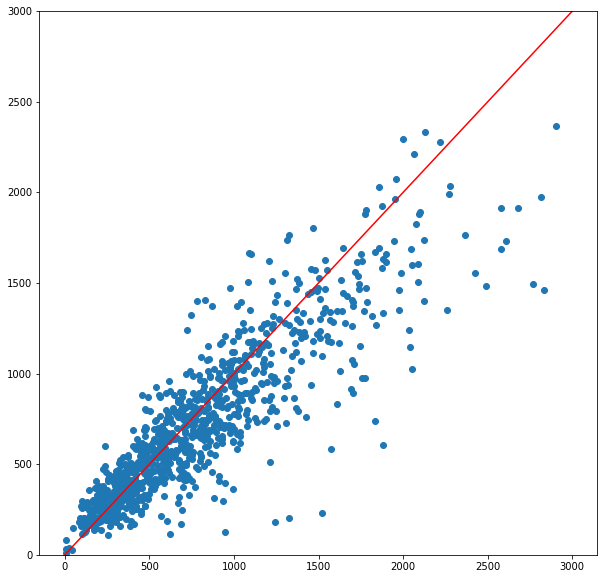

In [ ]:
plt.figure(figsize=(10,10))
x = test_labels[:1000]
y = y_pred
plt.ylim([0,3000])
plt.scatter(x,y)
X = np.asarray([int(i) for i in range(3000)])
Y = X
plt.plot(X,Y, 'r')
plt.show()